In [19]:
if (!require(survRM2)) install.packages('survRM2')
library('survRM2') 
if (!require(mvtnorm)) install.packages('mvtnorm')
library('mvtnorm')
if (!require(MASS)) install.packages('MASS')
library('MASS')
if (!require(survival)) install.packages('survival')
library('survival')
if (!require(nph)) install.packages('nph')
library('nph')
if (!require(foreach)) install.packages("foreach")
library('foreach') 
if (!require(doParallel)) install.packages("doParallel")
library('doParallel')
if (!require(ggplot2)) install.packages("ggplot2")
library('ggplot2')
if (!require(cowplot)) install.packages("cowplot")
library('cowplot')
if (!require(tidyr)) install.packages('tidyr')
library('tidyr')
library('IRdisplay')

n_cores <- detectCores()
cluster <- makeCluster(14) # How many cores we use
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster, #import packages to parallel 
  {
  library('survRM2')
  library('mvtnorm')
  library('cubature')
  library('survival')
  library('nph')
  library("simtrial")
  library("foreach")
  }))

source('Rfiles/3m_comparison.R')
source('Rfiles/Function.R')
clusterExport(cluster, "expo_gen_2stages")

# 3 Methods Comparison Under Proportional Hazard

### 2 stages Rejection region of overall:
### 1. Log rank test
#### $\textcolor{lightgreen}{\frac{W_1}{\sigma_1}>m_1\ \&\ \frac{W}{\sigma}>m_2}$
### 2. Simple RMST Difference
#### $ \textcolor{lightgreen}{E(\tau_1) - C(\tau_1) > m_1\ \&\  E(\tau_2)-C(\tau_2)>m_2 }$
### 3. Our RMST Rejection method
#### $ \textcolor{lightgreen}{E(\tau_1)-C(\tau_1)>m_1\ \&\  E(\tau_1)>t_1\ \&\  E(\tau_2)-C(\tau_2)>m_2\ \&\  E(\tau_2)>t_2}$
--------

#### <span style="color:yellow"> Setting in Jung's 2017 table 1 first row:
#### We set the total accrual time = 2 years and follow up 1 year
#### Recruit rate is 60(30 per arm) per year calculate the test power of 3 method controling $\alpha = 0.05$
#### <span style="color:yellow">We can only compare Minimax design since the default rule is searching for maximum stage I power


-----

# Differnent scenario 
#### <font color=yellow>Remarks: function 3m_comparison contains cocurrent foreach loop. 


## 1.  Different Hazard Ratio
### $\lambda_E = 0.83 = log(2)*12/10$. Median event time is around 10 months

In [13]:
set.seed(2024)
sim_size <- 5000
n <- ceiling(200 / 2)  # total sample size per arm
r <- 90  # patient recruit rate
acc_time <- 200 / r
cen_time <- 1
interim <- 120 / r
lambda_H1 <- 0.83
alpha <- 0.05

diff_delta <- foreach(delta = seq(1.2, 2, by = 0.1), .combine = rbind)%dopar%
    {
        lambda_H0 <- lambda_H1 * delta
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', alpha = alpha)
                
        c(delta, result$alpha, result$power, result$PET0, result$PET1)      
    }

In [18]:
diff_delta

result.1,1.2,0.0498,0.0498,0.0498,0.3252,0.3410,0.3410,0.3032,0.4810,0.4810,0.1274,0.2564,0.2564
result.2,1.3,0.0498,0.0498,0.0498,0.5166,0.5480,0.5480,0.3442,0.5086,0.5086,0.0950,0.1826,0.1826
result.3,1.4,0.0498,0.0498,0.0498,0.6994,0.7314,0.7314,0.3698,0.4972,0.4972,0.0586,0.1058,0.1058
result.4,1.5,0.0498,0.0494,0.0494,0.8258,0.8492,0.8492,0.3844,0.5090,0.5090,0.0394,0.0762,0.0762
result.5,1.6,0.0496,0.0494,0.0494,0.9116,0.9132,0.9132,0.3880,0.5104,0.5104,0.0256,0.0514,0.0514
result.6,1.7,0.0498,0.0496,0.0496,0.9538,0.9600,0.9600,0.3964,0.4860,0.4860,0.0162,0.0262,0.0262
result.7,1.8,0.0488,0.0472,0.0472,0.9844,0.9858,0.9858,0.4038,0.4872,0.4872,0.0042,0.0106,0.0106
result.8,1.9,0.0492,0.0472,0.0472,0.9912,0.9910,0.9910,0.4058,0.4908,0.4908,0.0044,0.0076,0.0076
result.9,2.0,0.0492,0.0354,0.0354,0.9978,0.9958,0.9958,0.4140,0.5090,0.5090,0.0014,0.0040,0.0040


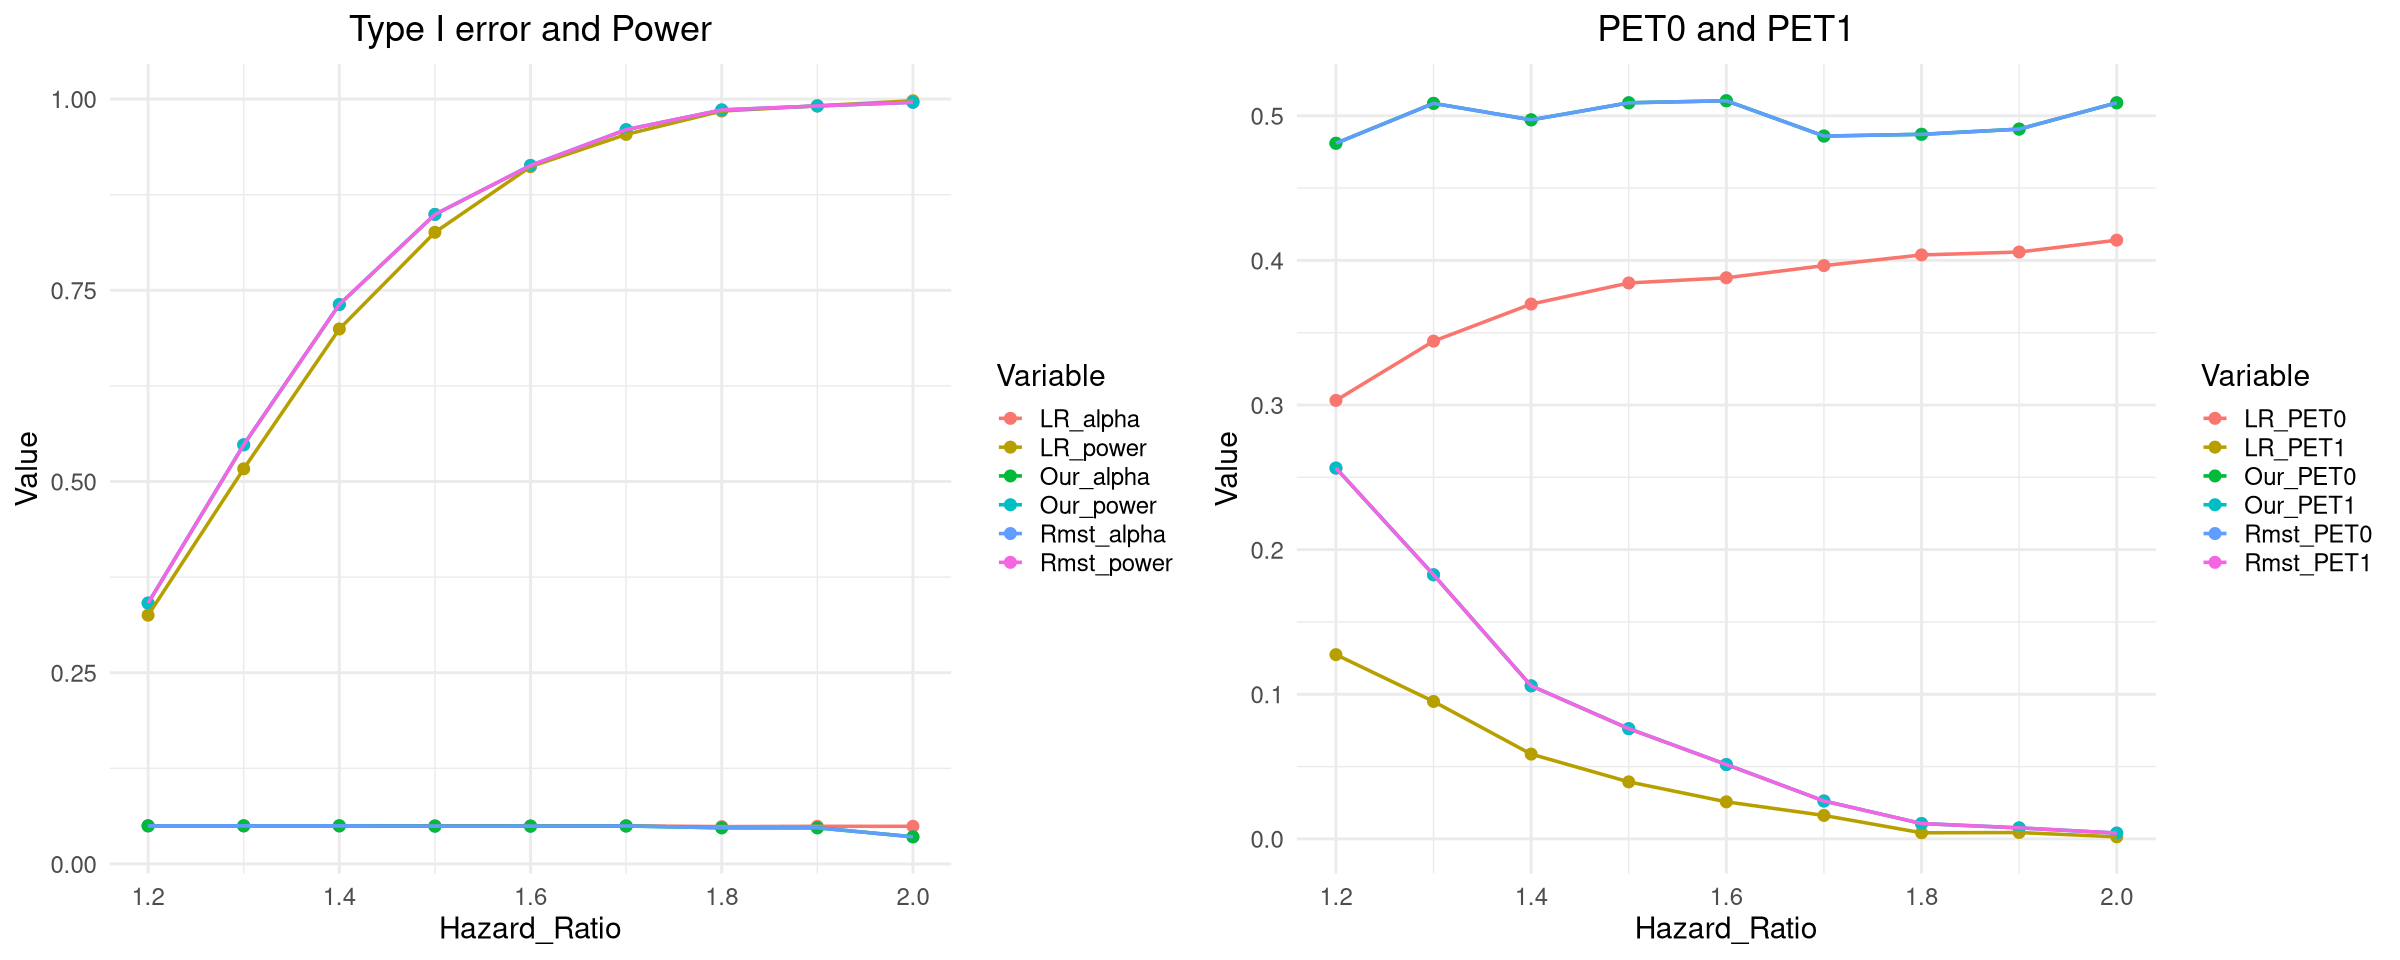

In [17]:
# save(diff_delta, file = '/home/r27user6/RMST_Code/RData/diff_delta.RData')
# load('/home/r27user6/RMST_Code/RData/diff_delta.RData')
options(repr.plot.width = 20, repr.plot.height = 8)

a_power_delta <- data.frame(diff_delta[, c(1,2,3,4,5,6,7)])
colnames(a_power_delta) <- c('Hazard_Ratio','LR_alpha','Rmst_alpha','Our_alpha',
                          'LR_power', 'Rmst_power','Our_power')
a_power_long <- a_power_delta %>%
  pivot_longer(cols = -Hazard_Ratio, names_to = "variable", values_to = "value")
plot1 <- ggplot(a_power_long, aes(x = Hazard_Ratio, y = value, color = variable)) +
  geom_point(size = 3) +
  geom_line(linewidth = 1) +
  labs(x = "Hazard_Ratio", y = "Value", color = "Variable",
      title = 'Type I error and Power') +
  theme_minimal(base_size = 18) + 
  theme(plot.title = element_text(hjust = 0.5))

pet_delta <- data.frame(diff_delta[, c(1,8,9,10,11,12,13)])
colnames(pet_delta) <- c('Hazard_Ratio','LR_PET0', 'Rmst_PET0', 'Our_PET0',
                      'LR_PET1', 'Rmst_PET1', 'Our_PET1')
pet_long <- pet_delta %>%
  pivot_longer(cols = -Hazard_Ratio, names_to = "variable", values_to = "value")
plot2 <- ggplot(pet_long, aes(x = Hazard_Ratio, y = value, color = variable)) +
  geom_point(size = 3) +
  geom_line(linewidth = 1) +
  labs(x = "Hazard_Ratio", y = "Value", color = "Variable",
      title = 'PET0 and PET1') +
  theme_minimal(base_size = 18) + 
  theme(plot.title = element_text(hjust = 0.5))

plot_grid(plot1, plot2, ncol = 2)

-----
## 2. Different interim period
### Interim period from 40% to 90% of the whole accrual period

In [5]:
set.seed(2024)
sim_size <- 5000
n <- ceiling(200 / 2)  # total sample size per arm
r <- 90  # patient recruit rate
acc_time <- 200 / r
cen_time <- 1
lambda_H1 <- 0.83
delta <- 1.5
lambda_H0 <- lambda_H1 * delta
alpha <- 0.05

diff_interim <- foreach(int_sam = seq(80, 180, by = 10), .combine = rbind) %do%
    {
        interim <- int_sam / r
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', alpha = alpha)
        c(interim, result$alpha, result$power, result$PET0, result$PET1)  
      
    }

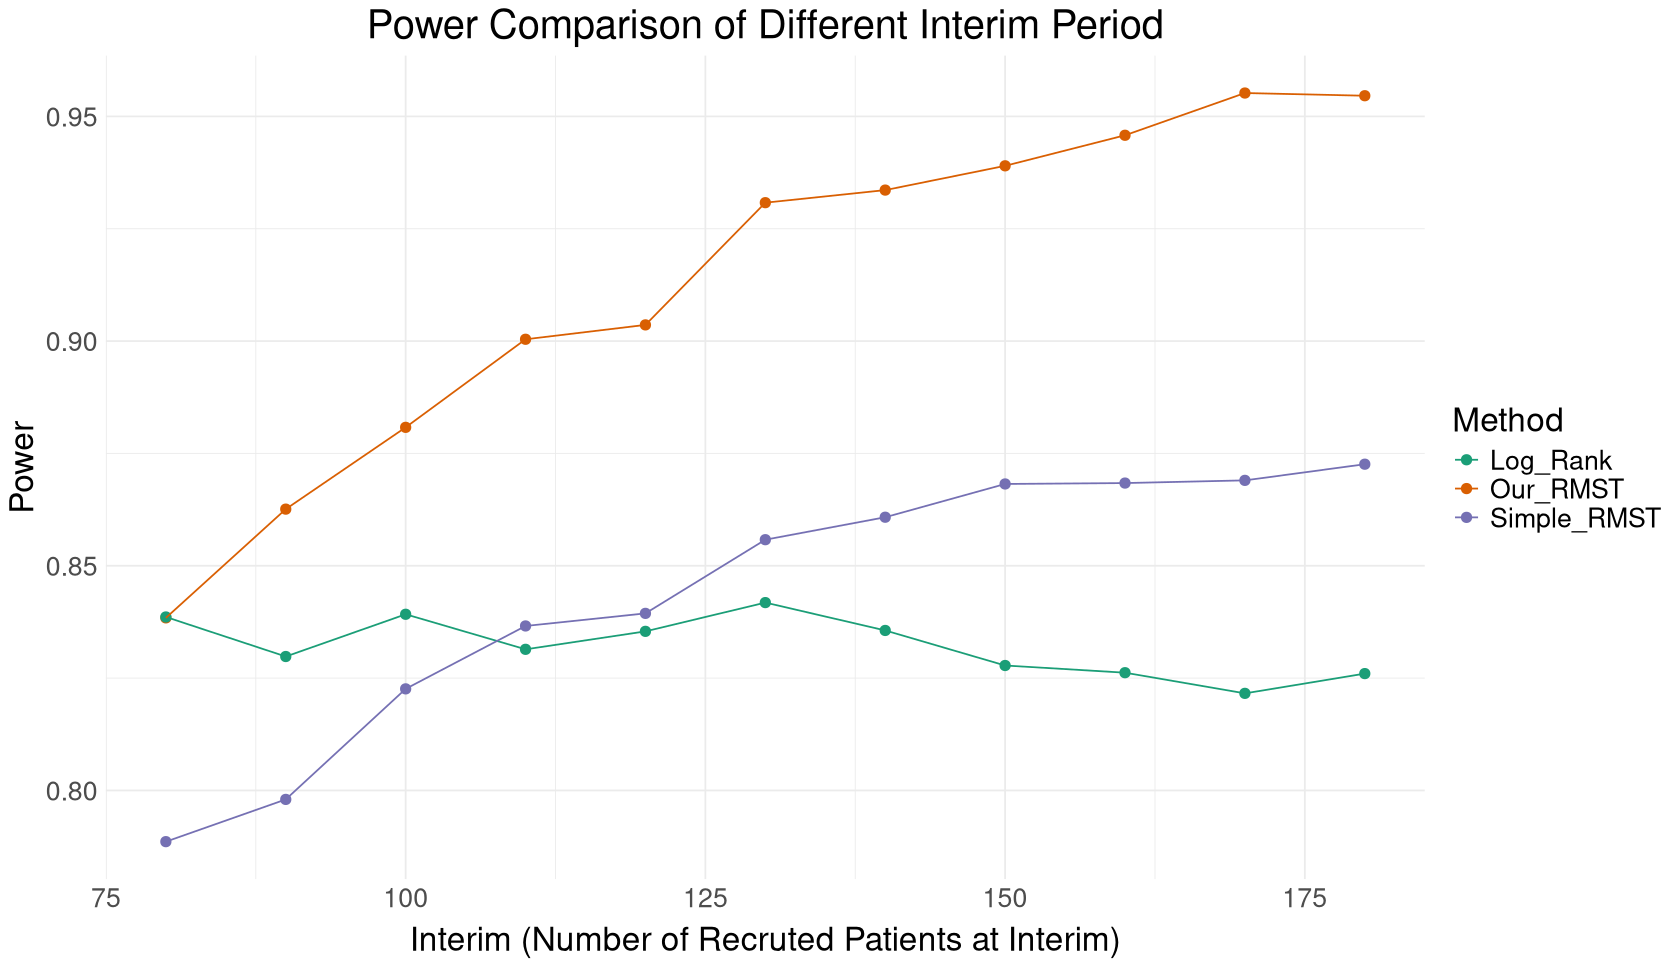

In [6]:
save(diff_interim, file = '/home/r27user6/RMST_Code/RData/diff_interim.RData')
load('/home/r27user6/RMST_Code/RData/diff_interim.RData')
options(repr.plot.width = 20, repr.plot.height = 8)

a_power_delta <- data.frame(diff_interim[, c(1,2,3,4,5,6,7)])
colnames(a_power_delta) <- c('Interim','LR_alpha','Rmst_alpha','Our_alpha',
                          'LR_power', 'Rmst_power','Our_power')
a_power_long <- a_power_delta %>%
  pivot_longer(cols = -Interim, names_to = "variable", values_to = "value")
plot1 <- ggplot(a_power_long, aes(x = Interim, y = value, color = variable)) +
  geom_point(size = 3) +
  geom_line(linewidth = 1) +
  labs(x = "Interim(year)", y = "Value", color = "Variable",
      title = 'Type I error and Power') +
  theme_minimal(base_size = 18) + 
  theme(plot.title = element_text(hjust = 0.5))

pet_delta <- data.frame(diff_interim[, c(1,8,9,10,11,12,13)])
colnames(pet_delta) <- c('Interim','LR_PET0', 'Rmst_PET0', 'Our_PET0',
                      'LR_PET1', 'Rmst_PET1', 'Our_PET1')
pet_long <- pet_delta %>%
  pivot_longer(cols = -Interim, names_to = "variable", values_to = "value")
plot2 <- ggplot(pet_long, aes(x = Interim, y = value, color = variable)) +
  geom_point(size = 3) +
  geom_line(linewidth = 1) +
  labs(x = "Interim(year)", y = "Value", color = "Variable",
      title = 'PET0 and PET1') +
  theme_minimal(base_size = 18) + 
  theme(plot.title = element_text(hjust = 0.5))

plot_grid(plot1, plot2, ncol = 2)

------
## 3. Different Recruit Rate
### Constant recruit rate. Smaller value means longer accrual time and interim period

In [7]:
set.seed(2024)
sim_size <- 5000
n <- ceiling(200 / 2)  # total sample size per arm
cen_time <- 1
lambda_H1 <- 0.83
delta <- 1.5
lambda_H0 <- lambda_H1 * delta
#grid search para__________
search_times <- 500
tar_a1 <- 0.8      #Upper bound of 1-PET0
tar_pow1_low <- 0  # lower bound of 1-PET1
tar_alpha <- 0.05

diff_rec_rate <- foreach(r = seq(40, 130, by = 10), .combine = rbind) %do%
    {
        acc_time <- 200 / r
        interim <- 120 / r
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', 
                search_times = search_times, tar_a1 = tar_a1, tar_pow1_low = tar_pow1_low, tar_alpha = tar_alpha)
        c(r, result$best_our_rmst$Power, result$best_simple_rmst$Power, result$best_log_rank$Power)      
    }

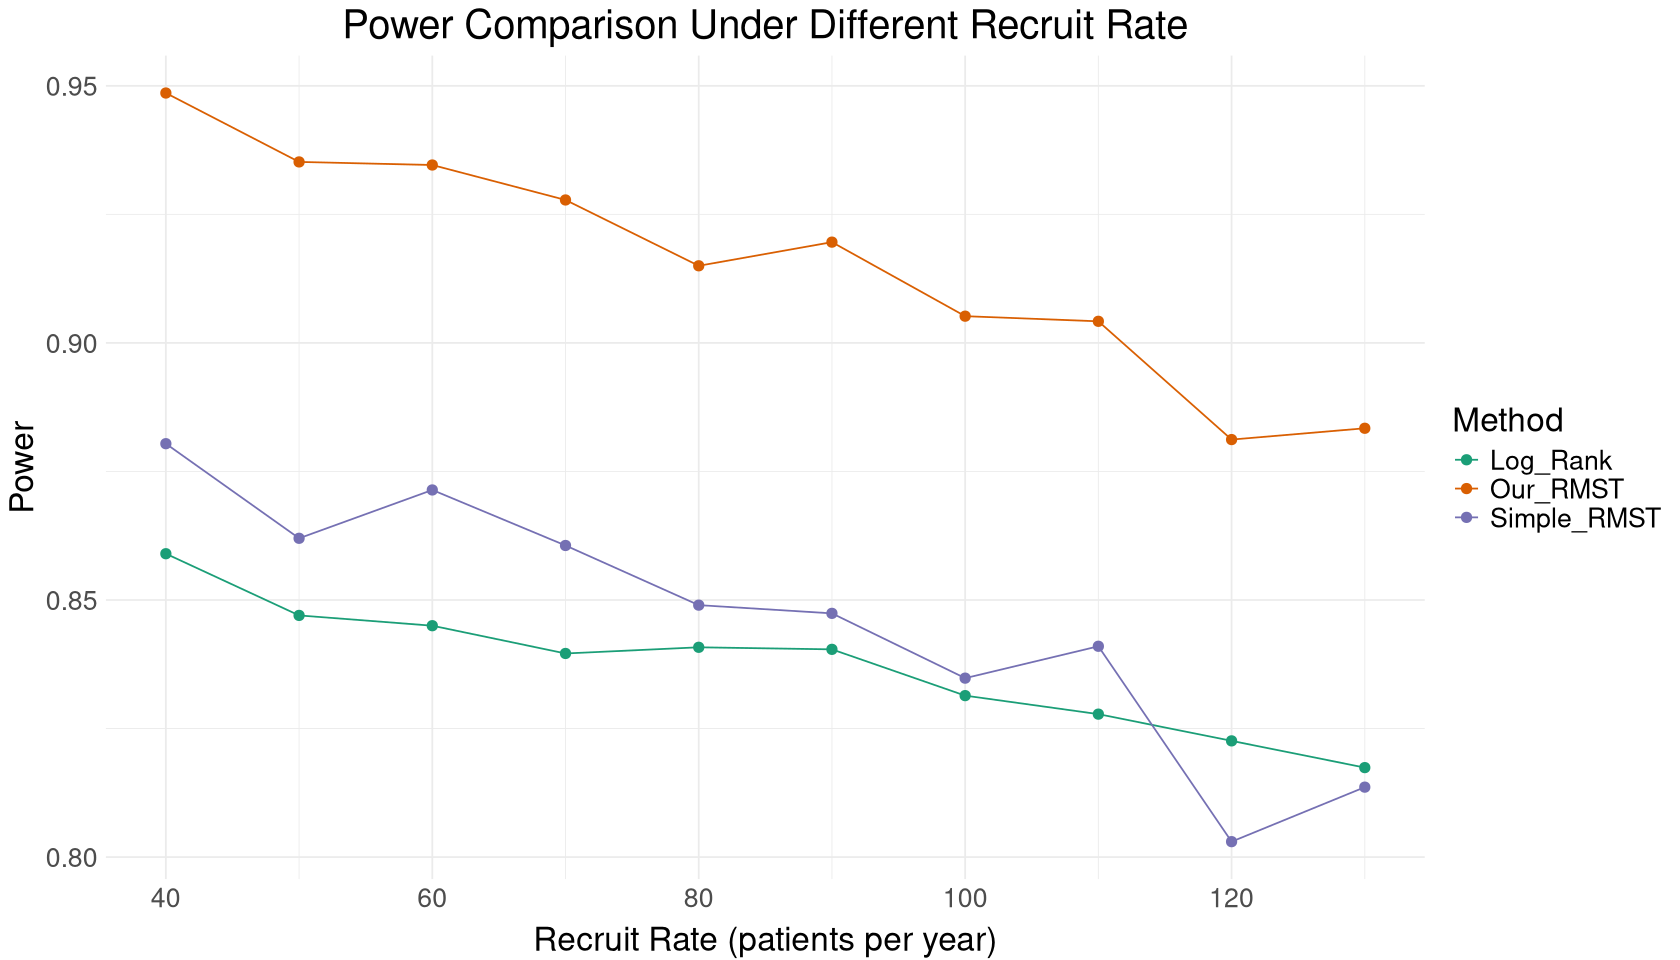

In [8]:
diff_rec_rate <- data.frame(diff_rec_rate)
colnames(diff_rec_rate) <- c('Recruit_rate','Our_RMST','Simple_RMST','Log_Rank')
save(diff_rec_rate, file = '/home/r27user6/RMST_Code/RData/diff_rec_rate.RData')
load('/home/r27user6/RMST_Code/RData/diff_rec_rate.RData')

diff_rec_rate_long <- diff_rec_rate %>% gather(key = "Method", value = "Power", -Recruit_rate)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(diff_rec_rate_long, aes(x = Recruit_rate, y = Power, color = Method)) +
  geom_point(size = 2.5) +
  geom_line() +
  scale_color_brewer(palette = "Dark2") +
  theme_minimal() +
  labs(
    color = "Method",
    title = "Power Comparison Under Different Recruit Rate",
    x = "Recruit Rate (patients per year)",
    y = "Power"
  ) +
  theme(text = element_text(size = 20),
        axis.title.x = element_text(vjust = 0),
        axis.title.y = element_text(vjust = 1),
        plot.title = element_text(hjust = 0.5))

------
## 4. Different $\lambda_E$
### Fix the hazard ratio, try different $\lambda$ of experiment group

In [12]:
set.seed(2024)
sim_size <- 5000
n <- ceiling(200 / 2)  # total sample size per arm
r <- 60
acc_time <- 200 / r
interim <- 120 / r
cen_time <- 1
delta <- 1.5
#grid search para__________
search_times <- 500
tar_a1 <- 0.65      #Upper bound of 1-PET0
tar_pow1_low <- 0  # lower bound of 1-PET1
tar_alpha <- 0.05

diff_lamb_e <- foreach(lambda_H1 = seq(0.5, 1, by = 0.05), .combine = rbind) %do%
    {
        lambda_H0 <- lambda_H1 * delta
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', 
                search_times = search_times, tar_a1 = tar_a1, tar_pow1_low = tar_pow1_low, tar_alpha = tar_alpha)
        c(lambda_H1, result$best_our_rmst$Power, result$best_simple_rmst$Power, result$best_log_rank$Power)      
    }

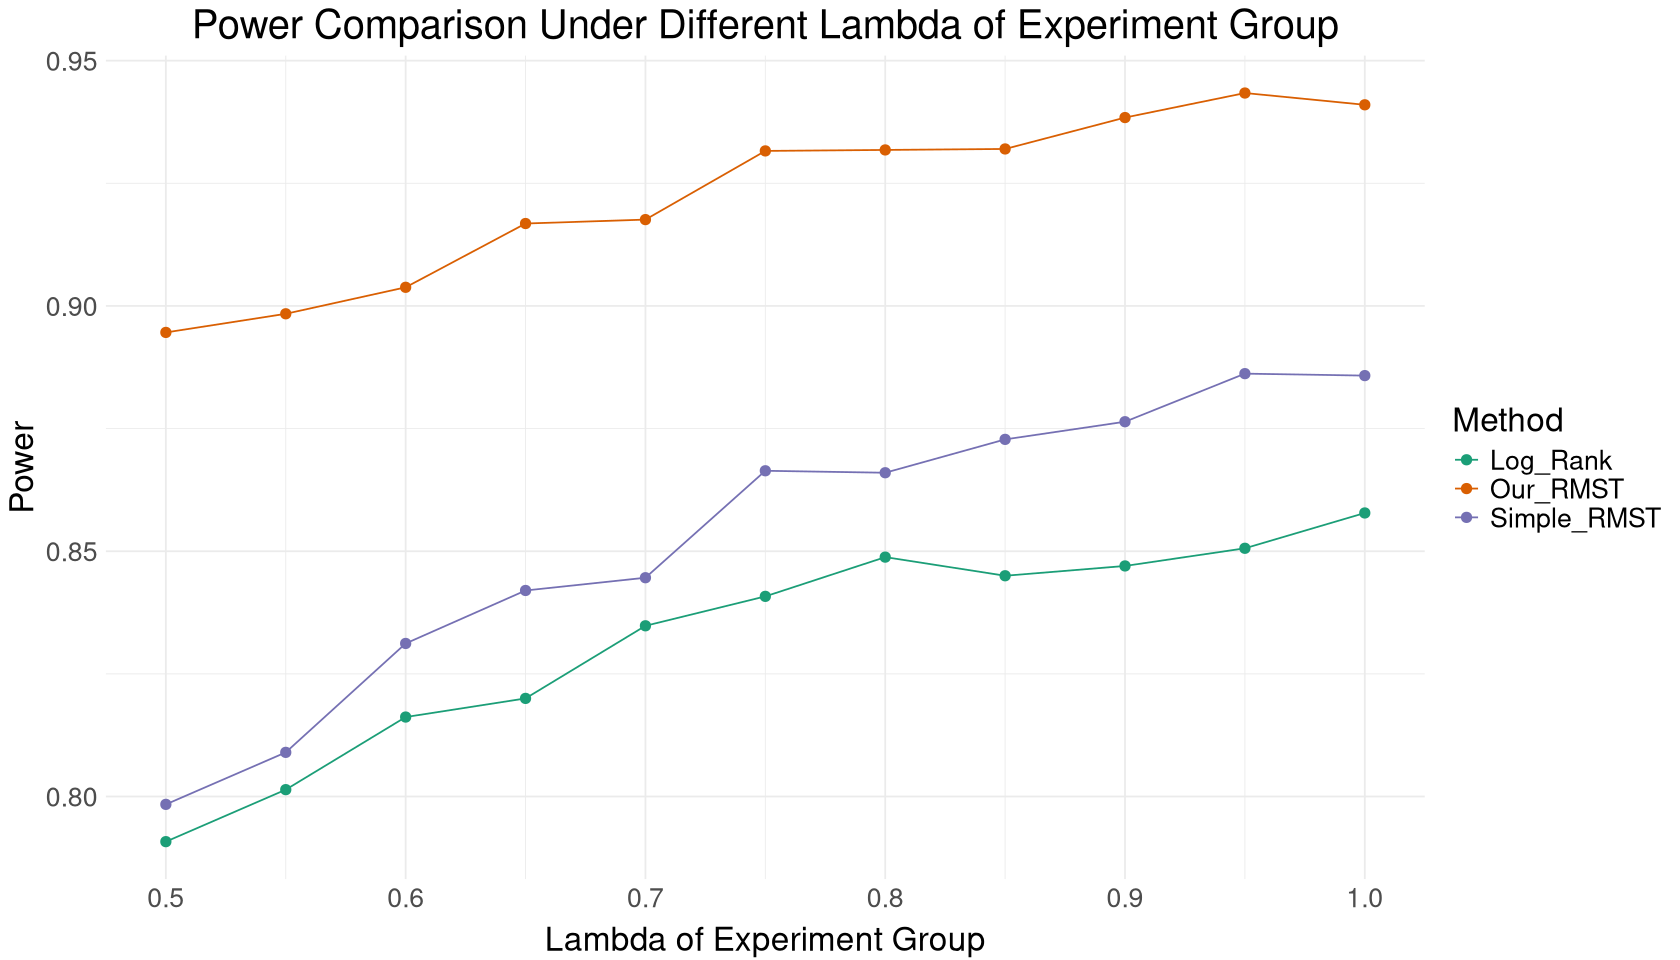

In [13]:
diff_lamb_e <- data.frame(diff_lamb_e)
colnames(diff_lamb_e) <- c('lambda_e','Our_RMST','Simple_RMST','Log_Rank')
save(diff_lamb_e, file = '/home/r27user6/RMST_Code/RData/diff_lamb_e.RData')
load('/home/r27user6/RMST_Code/RData/diff_lamb_e.RData')

diff_lamb_e_long <- diff_lamb_e %>% gather(key = "Method", value = "Power", -lambda_e)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(diff_lamb_e_long, aes(x = lambda_e, y = Power, color = Method)) +
  geom_point(size = 2.5) +
  geom_line() +
  scale_color_brewer(palette = "Dark2") +
  theme_minimal() +
  labs(
    color = "Method",
    title = "Power Comparison Under Different Lambda of Experiment Group",
    x = "Lambda of Experiment Group",
    y = "Power"
  ) +
  theme(text = element_text(size = 20),
        axis.title.x = element_text(vjust = 0),
        axis.title.y = element_text(vjust = 1),
        plot.title = element_text(hjust = 0.5))

-----
## 5. Different Follow Up Time : censoring distribution
### Censoring distribution $C \sim U [b , a + b]$, where b is the follow up time.
### We tune b from 0.6 to 1.6

In [14]:
set.seed(2024)
sim_size <- 5000
n <- ceiling(200 / 2)  # total sample size per arm
r <- 60
acc_time <- 200 / r
interim <- 120 / r
lambda_H1 <- 0.83
delta <- 1.5
lambda_H0 <- lambda_H1 * delta
#grid search para__________
search_times <- 500
tar_a1 <- 0.65      #Upper bound of 1-PET0
tar_pow1_low <- 0  # lower bound of 1-PET1
tar_alpha <- 0.05

diff_cen <- foreach(cen_time = seq(0.6, 1.6, by = 0.1), .combine = rbind) %do%
    {
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', 
                search_times = search_times, tar_a1 = tar_a1, tar_pow1_low = tar_pow1_low, tar_alpha = tar_alpha)
        c(cen_time, result$best_our_rmst$Power, result$best_simple_rmst$Power, result$best_log_rank$Power)      
    }

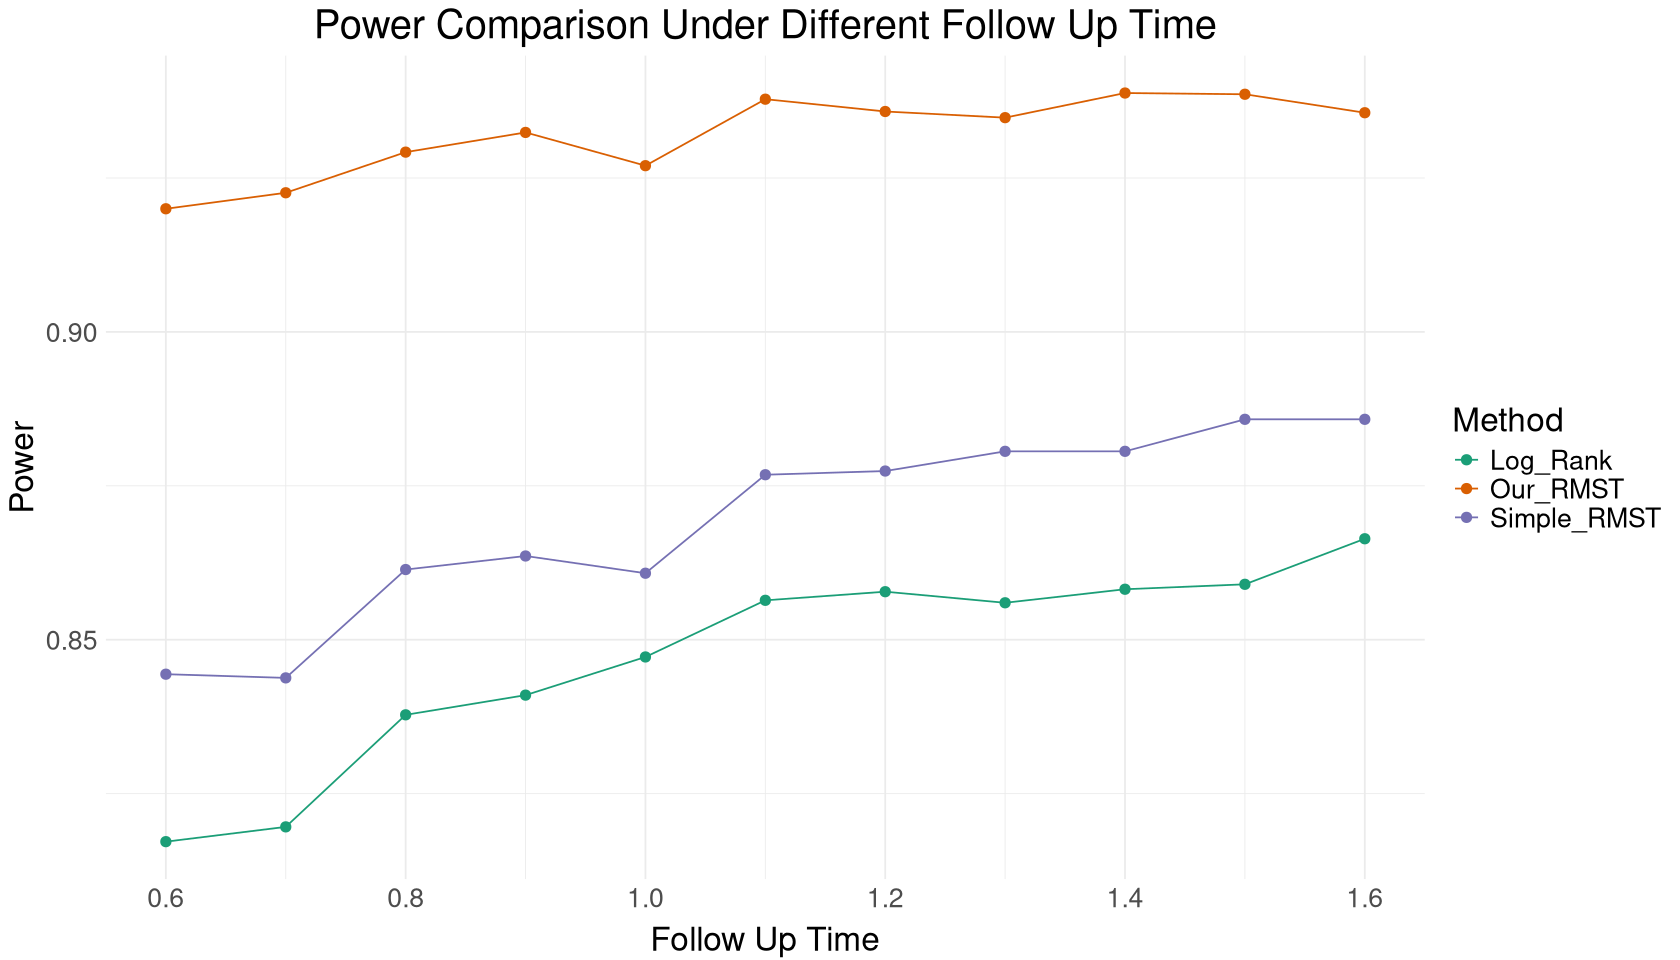

In [15]:
diff_cen <- data.frame(diff_cen)
colnames(diff_cen) <- c('cen_time','Our_RMST','Simple_RMST','Log_Rank')
save(diff_cen, file = '/home/r27user6/RMST_Code/RData/diff_cen.RData')
load('/home/r27user6/RMST_Code/RData/diff_cen.RData')

diff_cen_long <- diff_cen %>% gather(key = "Method", value = "Power", -cen_time)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(diff_cen_long, aes(x = cen_time, y = Power, color = Method)) +
  geom_point(size = 2.5) +
  geom_line() +
  scale_color_brewer(palette = "Dark2") +
  theme_minimal() +
  labs(
    color = "Method",
    title = "Power Comparison Under Different Follow Up Time",
    x = "Follow Up Time",
    y = "Power"
  ) +
  theme(text = element_text(size = 20),
        axis.title.x = element_text(vjust = 0),
        axis.title.y = element_text(vjust = 1),
        plot.title = element_text(hjust = 0.5))

------
## 6. Different PET0 (1 - $\alpha_1$)
### We search for the most powerful paramter under each setting. So PET0 need to be controled.
### We control PET0 from 0.1 to 0.6 by 0.05

In [16]:
set.seed(2024)
sim_size <- 5000
n <- ceiling(200 / 2)  # total sample size per arm
r <- 60
acc_time <- 200 / r
cen_time <- 1
interim <- 120 / r
lambda_H1 <- 0.83
delta <- 1.5
lambda_H0 <- lambda_H1 * delta
#grid search para__________
search_times <- 500
tar_pow1_low <- 0  # lower bound of 1-PET1
tar_alpha <- 0.05

diff_pet0 <- foreach(tar_a1 = seq(0.5, 0.9, by = 0.05), .combine = rbind) %do%
    {
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', 
                search_times = search_times, tar_a1 = tar_a1, tar_pow1_low = tar_pow1_low, tar_alpha = tar_alpha)
        c(1-tar_a1, result$best_our_rmst$Power, result$best_simple_rmst$Power, result$best_log_rank$Power)      
    }

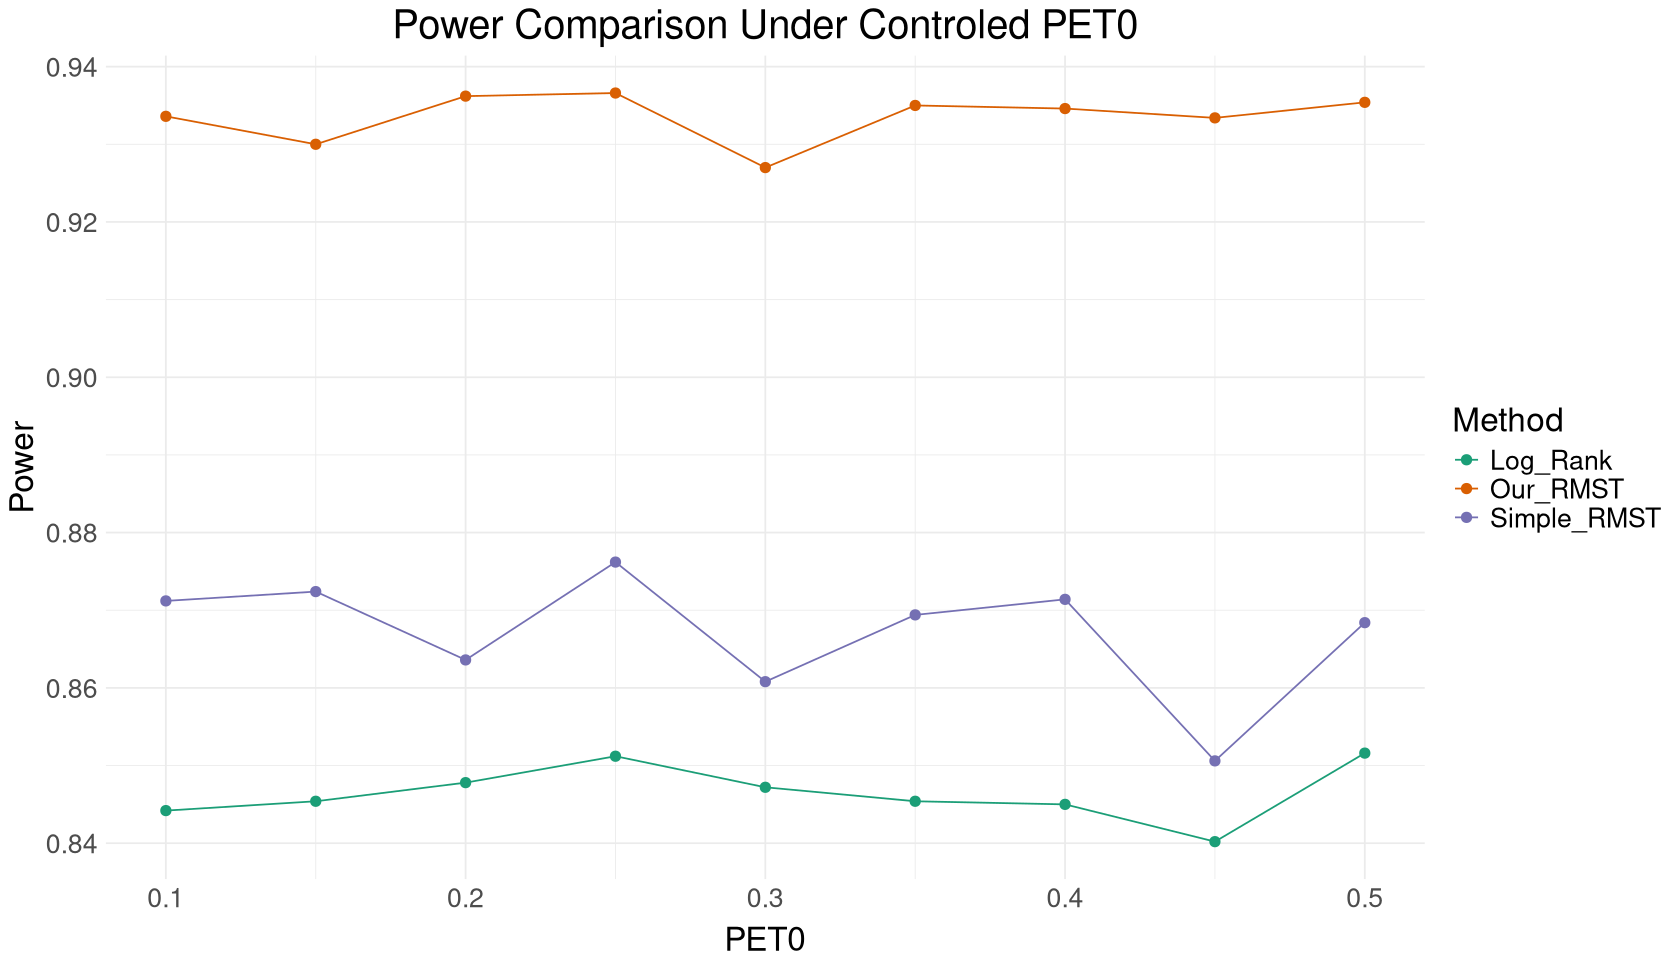

In [17]:
diff_pet0 <- data.frame(diff_pet0)
colnames(diff_pet0) <- c('PET0','Our_RMST','Simple_RMST','Log_Rank')
save(diff_pet0, file = '/home/r27user6/RMST_Code/RData/diff_pet0.RData')
load('/home/r27user6/RMST_Code/RData/diff_pet0.RData')

diff_pet0_long <- diff_pet0 %>% gather(key = "Method", value = "Power", -PET0)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(diff_pet0_long, aes(x = PET0, y = Power, color = Method)) +
  geom_point(size = 2.5) +
  geom_line() +
  scale_color_brewer(palette = "Dark2") +
  theme_minimal() +
  labs(
    color = "Method",
    title = "Power Comparison Under Controled PET0",
    x = "PET0",
    y = "Power"
  ) +
  theme(text = element_text(size = 20),
        axis.title.x = element_text(vjust = 0),
        axis.title.y = element_text(vjust = 1),
        plot.title = element_text(hjust = 0.5))

-----
# Optimal design search 

In [5]:
set.seed(2024)
sim_size <- 5000
n_low <- ceiling(0.8 * 174 / 2)  #log rank minimax
n_up <- ceiling (1.2 * 187 / 2)  # log rank optimal
n_list <- seq(from = n_low, to = n_up, by = 1)

r <- 60
cen_time <- 1
lambda_H1 <- 0.9
delta <- 1.5
lambda_H0 <- lambda_H1 * delta

dataset_tab1_row1 <- foreach(n = n_list, .combine = 'cbind') %dopar% 
  {
    acc_time <- n * 2 / r
    interim_sam_list <- seq(from = ceiling(0.5 * n), to = ceiling(0.8 * n), by = 2)  #interim sample size
    interim_list <- interim_sam_list * 2 / r
    inner_results <- array(NA,dim = c(8, sim_size, length(interim_list)))

    data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time, arm = 0, interim = interim_list)    
    data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time, arm = 1, interim = interim_list) 
    data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                            cen_time = cen_time, arm = 1, interim = interim_list)         
  # Interim
    for (i in 1:length(interim_list)) 
      {
        interim <- interim_list[i]
        int_sam <- interim_sam_list[i]
        rmst_h0_int <- RMST_sim_cal(n = n,data_E = data_E_H0[ , c(2,3,1), i], 
                                data_C = data_C[ , c(2,3,1), i], tau = interim, sim_size = sim_size)
        rmst_h1_int <- RMST_sim_cal(n = n,data_E = data_E_H1[ , c(2,3,1), i], 
                                data_C = data_C[ , c(2,3,1), i], tau = interim, sim_size = sim_size)
        rmst_h0_fin <- RMST_sim_cal(n = n,data_E = data_E_H0[ , c(4,5,1), i], 
                                data_C = data_C[ , c(4,5,1), i],tau = acc_time + cen_time,sim_size = sim_size)
        rmst_h1_fin <- RMST_sim_cal(n = n,data_E = data_E_H1[ , c(4,5,1), i], 
                                data_C = data_C[ , c(4,5,1), i],tau = acc_time + cen_time,sim_size = sim_size)
        rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)
        inner_results[, , i] <- rmst_data
      }

  list(int_sam = interim_sam_list, data = inner_results)
}



#### These data files are too large to be uploaded to Github

In [7]:
save(dataset_tab1_row1, file = '/home/r27user6/RMST_Code/RData/dataset_tab1_row1.RData')